# 유수분 밸런스 EDA


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import sys

In [7]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
%matplotlib inline

plt.style.use("ggplot")

In [8]:
#분석 관련
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from statsmodels.formula.api import ols

In [104]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [10]:
import pickle

# 파일 불러오기
train = pd.read_pickle('../data/train_nona.pkl')
#train = pd.read_excel('./data/train_nona.xlsx')
#submission = pd.read_csv('./data/sample_submission.csv')

In [11]:
train.head()

,측정기기,"시,도",년,월,일,시,시간대,연령,연령대,성별,피부타입,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,스킨터치1,광주광역시,2014,3,29,19,저녁,21.0,20.0,여자,4.0,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0
1,스킨터치1,서울특별시,2012,12,29,20,저녁,22.0,20.0,여자,6.0,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0
2,스킨터치1,서울특별시,2013,12,18,20,저녁,22.0,20.0,여자,3.0,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0
3,스킨터치1,부산광역시,2013,8,31,15,오후,22.0,20.0,여자,4.0,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0
4,스킨터치1,부산광역시,2012,7,29,18,저녁,23.0,20.0,여자,4.0,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0


# 수분 데이터 확인

In [12]:
train['수분'].describe()

count    513528.000000
mean         46.910665
std          16.079374
min           1.000000
25%          38.000000
50%          45.000000
75%          54.000000
max          99.000000
Name: 수분, dtype: float64

최대 99, 최소 1로 유수분 비율을 구하는데는 문제 없다.

# 유분 데이터 확인

In [13]:
train['유분'].describe()

count    513528.000000
mean         41.941285
std          32.161210
min           0.000000
25%          14.000000
50%          36.000000
75%          65.000000
max          99.000000
Name: 유분, dtype: float64

최소값 0으로, 유분만 분모에 들어가면 안된다.

그래서, 수분+유분을 분모로

# 유수분 밸런스 컬럼 제작

In [14]:
train['유수분'] = train['유분']/(train['수분']+train['유분'])
train.head()

,측정기기,"시,도",년,월,일,시,시간대,연령,연령대,성별,...,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지,유수분
0,스킨터치1,광주광역시,2014,3,29,19,저녁,21.0,20.0,여자,...,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0,0.244275
1,스킨터치1,서울특별시,2012,12,29,20,저녁,22.0,20.0,여자,...,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0,0.467742
2,스킨터치1,서울특별시,2013,12,18,20,저녁,22.0,20.0,여자,...,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0,0.057143
3,스킨터치1,부산광역시,2013,8,31,15,오후,22.0,20.0,여자,...,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0,0.287770
4,스킨터치1,부산광역시,2012,7,29,18,저녁,23.0,20.0,여자,...,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0,0.317241


# 탄력 시각화

- 유수분, 탄력 시각화를 위해서 탄력이 범주화가 가능한지 확인

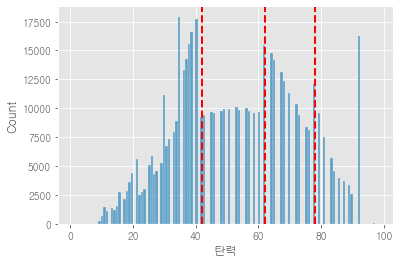

In [15]:
sns.histplot(train['탄력'])
plt.axvline(x=42, color='r', linestyle='--', linewidth=2)
plt.axvline(x=62, color='r', linestyle='--', linewidth=2)
plt.axvline(x=78, color='r', linestyle='--', linewidth=2)


- 42 이하 D
- 62 이하 C
- 78 이하 B
- 그 이상 A

총 4개의 범주로 나눠서 시각화

In [16]:
train['탄력_bin']=pd.cut(train['탄력'],bins=[0,42,62,78,100],labels=['D','C','B','A'])

In [17]:
train['탄력_bin']

0         A
1         A
2         A
3         A
4         A
         ..
553043    D
553044    D
553045    D
553046    D
553047    D
Name: 탄력_bin, Length: 513528, dtype: category
Categories (4, object): ['D' < 'C' < 'B' < 'A']

<AxesSubplot:xlabel='탄력_bin', ylabel='Count'>

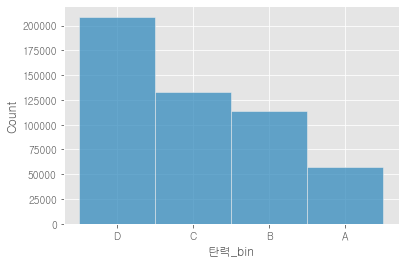

In [18]:
sns.histplot(train['탄력_bin'])

In [19]:
train['탄력_bin'].value_counts().to_frame().style.background_gradient(cmap='summer')

,탄력_bin
D,208951
C,132980
B,114189
A,57408


## 유분과 탄력

<AxesSubplot:xlabel='유분', ylabel='Count'>

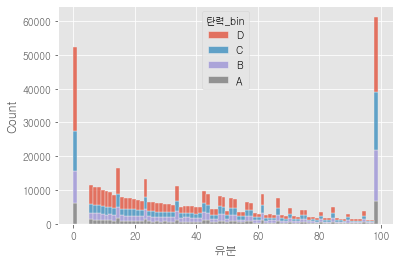

In [20]:
sns.histplot(x=train['유분'],hue=train['탄력_bin'],multiple='stack')

## 미세먼지와 탄력

<AxesSubplot:xlabel='미세먼지', ylabel='Count'>

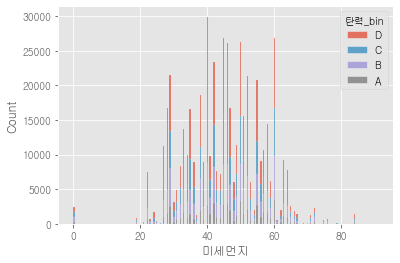

In [21]:
sns.histplot(x=train['미세먼지'],hue=train['탄력_bin'],multiple='stack')

#  유수분, 탄력 시각화

## 유수분 일변량

<AxesSubplot:xlabel='유수분', ylabel='Count'>

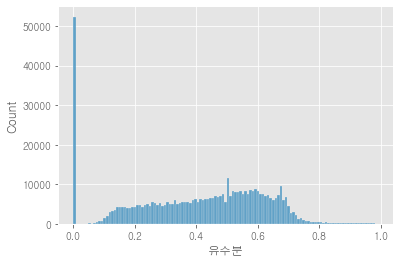

In [22]:
sns.histplot(train['유수분'])

In [23]:
train['유수분'].describe()

count    513528.000000
mean          0.407214
std           0.214786
min           0.000000
25%           0.250000
50%           0.442857
75%           0.579832
max           0.990000
Name: 유수분, dtype: float64

최대 비율 0.99, 최소 0

최소 점에 위치한 경우가 제일 많다.(유분이 0 인 경우)

0.3정도가 최적일것이라고 가설을 설정함.

## 유수분 이변량

### 탄력 범주를 통한 시각화

<AxesSubplot:xlabel='유수분', ylabel='Count'>

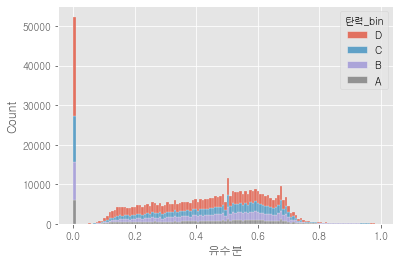

In [24]:
sns.histplot(x=train['유수분'],hue=train['탄력_bin'],multiple='stack')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

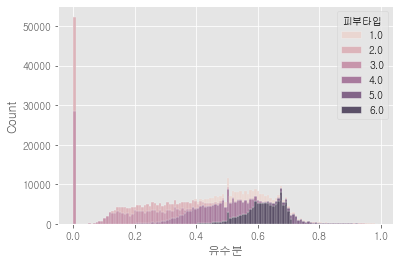

In [25]:
sns.histplot(x=train['유수분'],hue=train['피부타입'],multiple='stack')

<AxesSubplot:xlabel='유분', ylabel='Count'>

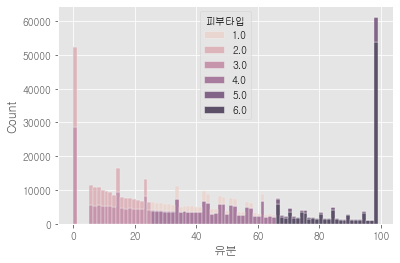

In [26]:
sns.histplot(x=train['유분'],hue=train['피부타입'],multiple='stack')

<AxesSubplot:xlabel='수분', ylabel='Count'>

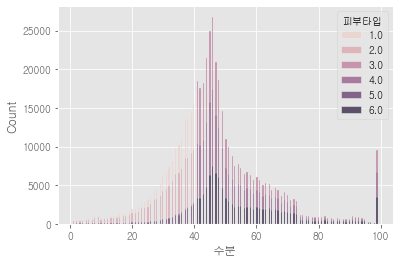

In [27]:
sns.histplot(x=train['수분'],hue=train['피부타입'],multiple='stack')

예상과 달리 골고루 탄력이 분포한다...

<AxesSubplot:xlabel='유수분', ylabel='탄력_bin'>

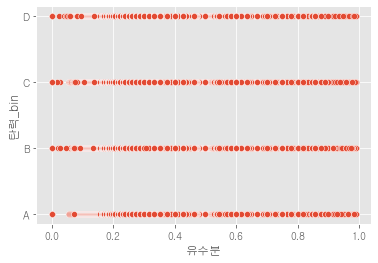

In [28]:
sns.scatterplot(x=train['유수분'],y=train['탄력_bin'])

In [29]:
train[['유수분','유분','수분','탄력']].corr()

,유수분,유분,수분,탄력
유수분,1.000000,0.863979,-0.060420,0.090076
유분,0.863979,1.000000,0.269872,0.072333
수분,-0.060420,0.269872,1.000000,-0.026374
탄력,0.090076,0.072333,-0.026374,1.000000


탄력과 유수분이 0.09 밖에 상관성이 없다.

나머지 변수도 상관성이 없게 관측된다.

피부의 건강도를 측정할 다른 변수가 필요한 것으로 생각된다.

# 결론

- 유수분 밸런스가 탄력을 설명해주지는 못한다.
- 탄력외의 다른 변수를 찾아야할지.
- 또는 유수분 밸런스 공식을 새로 생각해봐야 할지.
- 피부타입=유수분 과 탄력성은 상관성이 없다.
- 수분과 탄력은 음의 상관을 가진다.
- 피부타입은 유분에 따라 나눈것으로 보인다.

1. 피부타입 해석. 모델을 나눠보기. 탄력보기.

2. y를 수분으로 넣고, 예측

# 피부 타입에 따른 데이터

## 피부 타입과 탄력

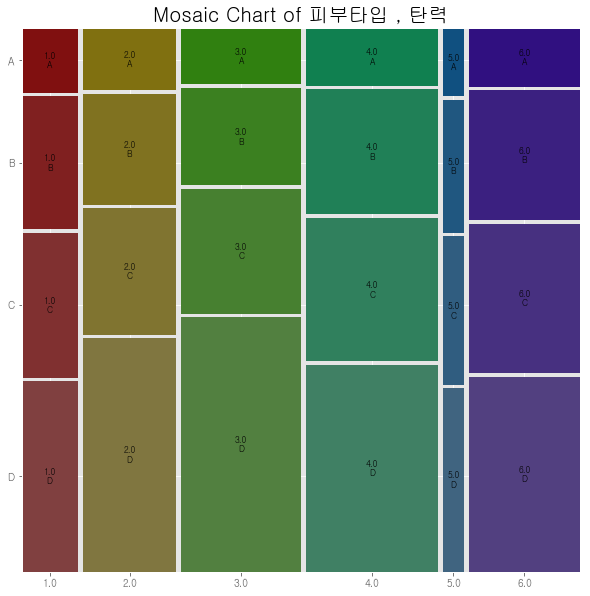

In [30]:
plt.rcParams["figure.figsize"]=(10,10)

mosaic(train, ['피부타입', '탄력_bin'],gap=0.01,label_rotation=True)


plt.title('Mosaic Chart of 피부타입 , 탄력', fontsize=20)

plt.show()
plt.rcParams["figure.figsize"]=(6.0,4.0)

피부 타입에 따라 탄력은 A에서는 큰차이가 없다.

하지만, B,C,D,에서 차이가 보인다.

각 피부 타입안에서, 왜 그룹이 나눠지는거지?

In [31]:
type_crosstab=pd.crosstab(train['피부타입'],train['탄력_bin'])
type_crosstab_res=chi2_contingency(type_crosstab)

In [32]:
print('Chi2 Statistic: {}, p-value: {}'.format(type_crosstab_res[0], type_crosstab_res[1]))
print('기각')

Chi2 Statistic: 5056.136448563118, p-value: 0.0
기각


검정 결과 피부 타입과 탄력은 독립이 아님을 알 수 있다.

다만, 탄력이 좋은 사람에서는 구분력이 없지만,

In [33]:
type_crosstab

탄력_bin,D,C,B,A
피부타입,,,,
1.0,19406,14765,13541,6598
2.0,39242,21224,18658,10490
3.0,55170,27117,21185,12242
4.0,49251,34316,29819,13739
5.0,6812,5515,4941,2544
6.0,39070,30043,26045,11795


<AxesSubplot:xlabel='피부타입'>

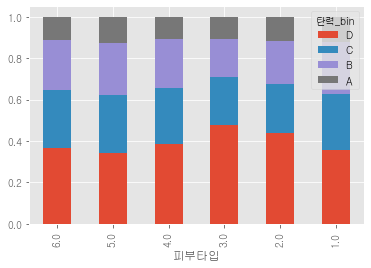

In [34]:
def ratio_table(cross_tab):
    return cross_tab.div(cross_tab.sum(axis=1),axis='index')

type_ratio=ratio_table(type_crosstab)
type_ratio=type_ratio.sort_values(by='피부타입',ascending=False)

type_ratio.plot(kind='bar',stacked=True)

## 피부타입과 유분

<AxesSubplot:xlabel='유분', ylabel='Count'>

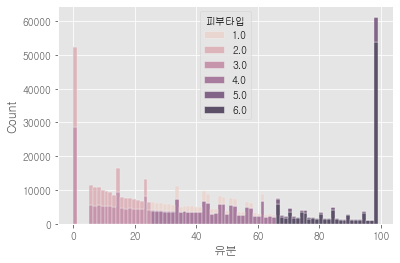

In [35]:
sns.histplot(x=train['유분'],hue=train['피부타입'],multiple='stack')

<AxesSubplot:xlabel='유분', ylabel='Count'>

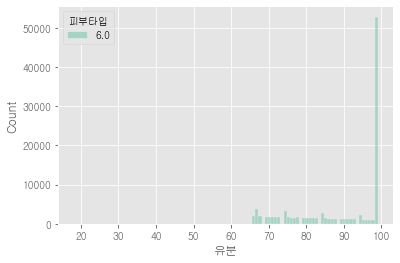

In [36]:
sns.histplot(x=train['유분'],hue=train[train['피부타입']==6]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유분', ylabel='Count'>

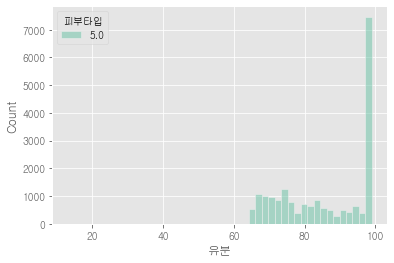

In [37]:
sns.histplot(x=train['유분'],hue=train[train['피부타입']==5]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유분', ylabel='Count'>

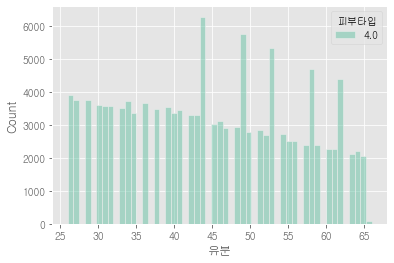

In [38]:
sns.histplot(x=train['유분'],hue=train[train['피부타입']==4]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유분', ylabel='Count'>

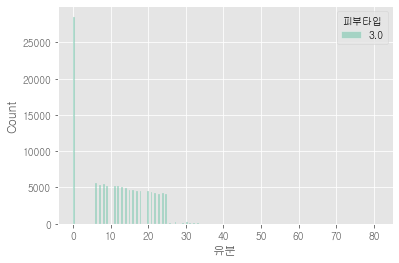

In [39]:
sns.histplot(x=train['유분'],hue=train[train['피부타입']==3]['피부타입'], palette='Set2')

피부타입은 유분에 따라 나눈것으로 보인다.

숫자가 높을 수록 지성피부

## 피부타입과 유수분

<AxesSubplot:xlabel='유수분', ylabel='Count'>

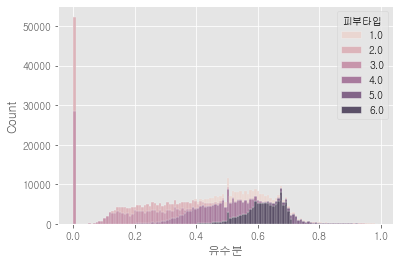

In [40]:
sns.histplot(x=train['유수분'],hue=train['피부타입'],multiple='stack')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

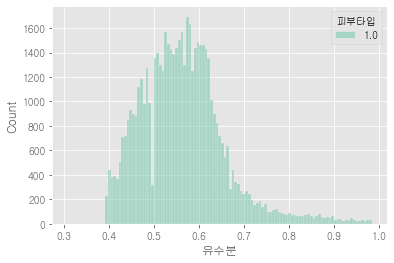

In [41]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==1]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

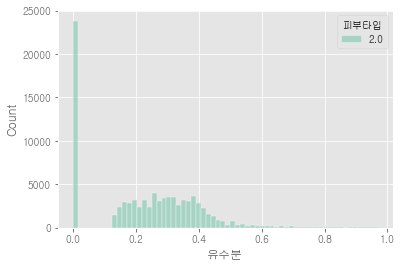

In [42]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==2]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

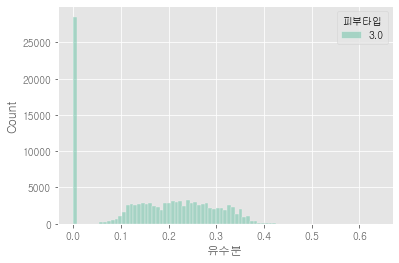

In [43]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==3]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

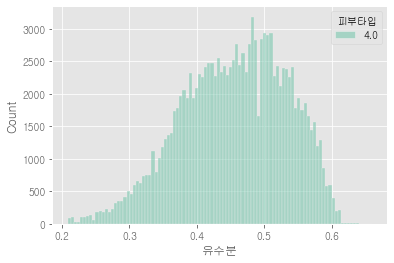

In [44]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==4]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

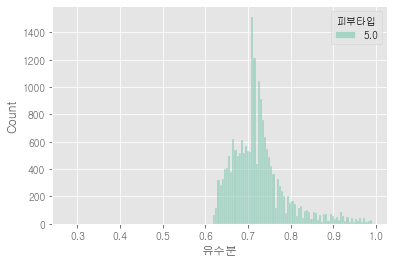

In [45]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==5]['피부타입'], palette='Set2')

<AxesSubplot:xlabel='유수분', ylabel='Count'>

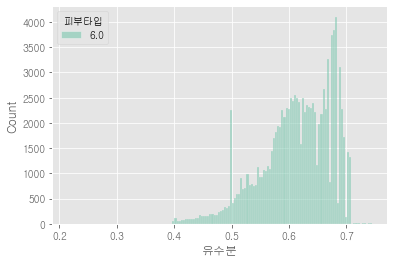

In [46]:
sns.histplot(x=train['유수분'],hue=train[train['피부타입']==6]['피부타입'], palette='Set2')

## 피부타입과 수분

유분이 피부타입을 설명한다면,

어느정도 수분을 설명할 수 있다.

<AxesSubplot:xlabel='수분', ylabel='Count'>

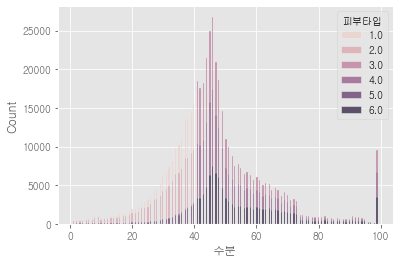

In [47]:
sns.histplot(x=train['수분'],hue=train['피부타입'],multiple='stack')

피부타입, 유수분 피부타입, 탄력 피부타입.

사람들의 특성을 찾자.



# 그외 변수

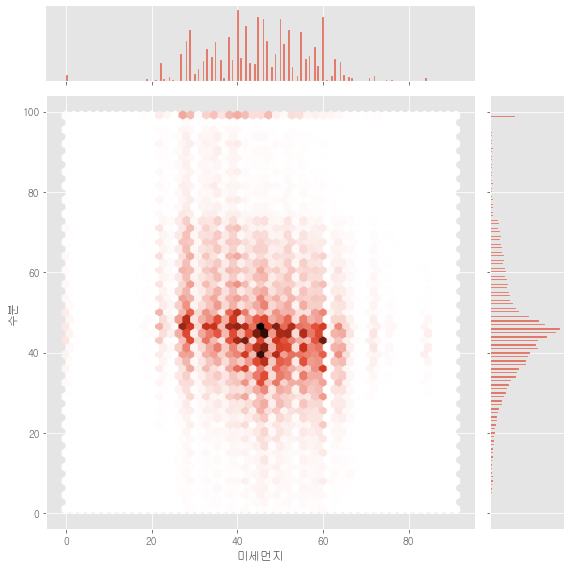

In [48]:

sns.jointplot(x=train['미세먼지'], y=train['수분'], kind='hex', height=8,palette='Paired')
plt.show()

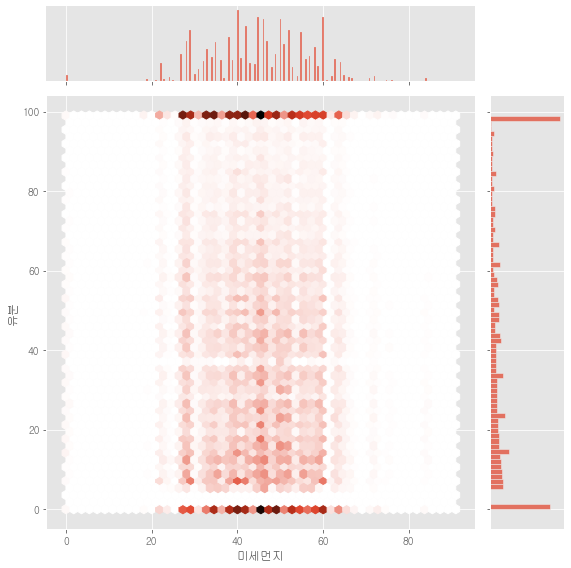

In [49]:

sns.jointplot(x=train['미세먼지'], y=train['유분'], kind='hex', height=8,palette='Paired')
plt.show()

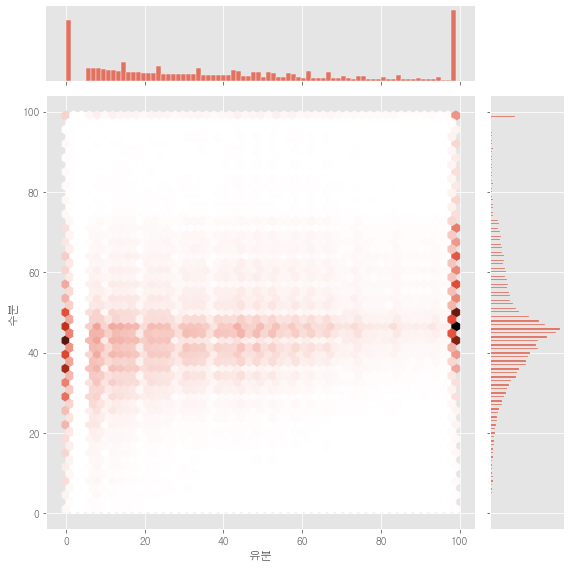

In [50]:

sns.jointplot(x=train['유분'], y=train['수분'], kind='hex', height=8,palette='Paired')
plt.show()

# 커스텀 피부타입 제작

기존에서 제공해주는 피부타입을 넘어서 ,각 컬럼별로 피부타입을 제작하고 cluster를 찾아보자.

즉, 각 컬럼을 범주화 하고, 범주형 자료를 cluster해보자.


- 유수분 피부타입
- 탄력 피부타입
- 피부타입

<AxesSubplot:xlabel='수분', ylabel='Count'>

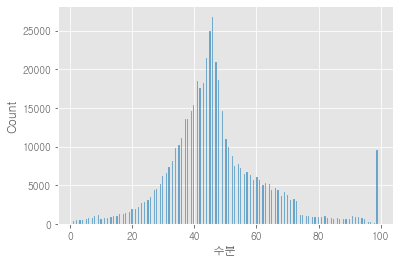

In [51]:
sns.histplot(x=train['수분'])

<AxesSubplot:xlabel='유수분', ylabel='Count'>

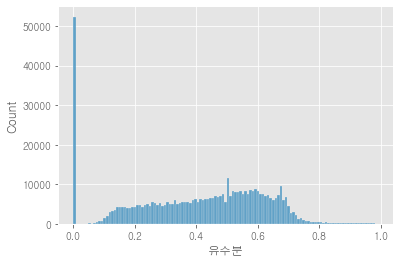

In [52]:
sns.histplot(x=train['유수분'])

<AxesSubplot:xlabel='탄력', ylabel='Count'>

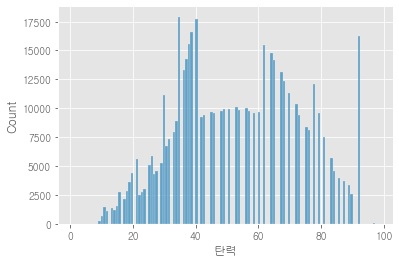

In [53]:
sns.histplot(x=train['탄력'])

In [54]:
train[['탄력','유수분','수분']].corr()

,탄력,유수분,수분
탄력,1.000000,0.090076,-0.026374
유수분,0.090076,1.000000,-0.060420
수분,-0.026374,-0.060420,1.000000


In [85]:
data = train[['탄력','유수분','수분']]
data

,탄력,유수분,수분
0,92.0,0.244275,99.0
1,92.0,0.467742,99.0
2,92.0,0.057143,99.0
3,92.0,0.287770,99.0
4,92.0,0.317241,99.0
...,...,...,...
553043,16.0,0.968750,1.0
553044,16.0,0.980000,1.0
553045,12.0,0.947368,1.0
553046,11.0,0.990000,1.0


In [86]:
from scipy.cluster.hierarchy import fcluster
predict = pd.DataFrame(fcluster(data,2,criterion='distance'))
predict.columns=['predict']
ct = pd.crosstab(predict['predict'],labels['labels'])
print(ct)


ValueError: Linkage matrix 'Z' must have 4 columns.

<AxesSubplot:xlabel='유수분', ylabel='탄력'>

C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


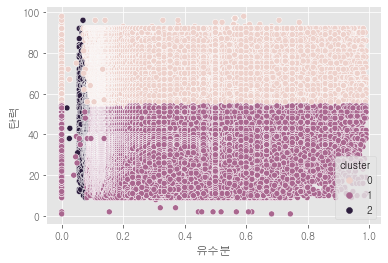

In [95]:
sns.scatterplot(x=data['유수분'],y=data['탄력'],hue=data['cluster'])

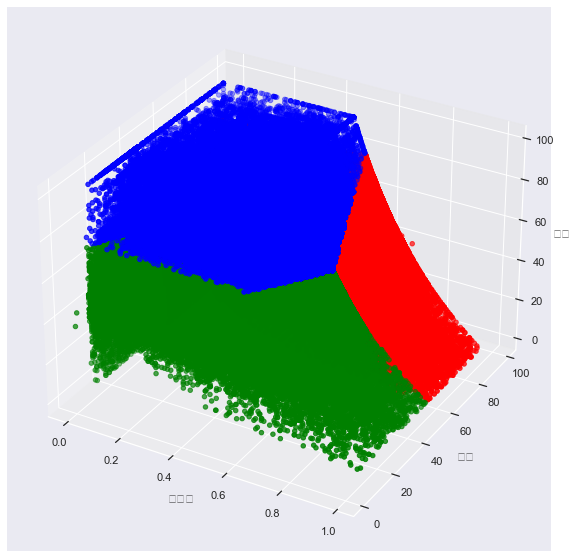

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x = data[data['cluster']==0]['유수분']
y = data[data['cluster']==0]['탄력']
z = data[data['cluster']==0]['수분']

ax.scatter(x, y, z,color='red')

x = data[data['cluster']==1]['유수분']
y = data[data['cluster']==1]['탄력']
z = data[data['cluster']==1]['수분']

ax.scatter(x, y, z,color='green')

x = data[data['cluster']==2]['유수분']
y = data[data['cluster']==2]['탄력']
z = data[data['cluster']==2]['수분']
ax.scatter(x, y, z,color='blue')


ax.set_xlabel("유수분")
ax.set_ylabel("탄력")
ax.set_zlabel("수분")

plt.show()

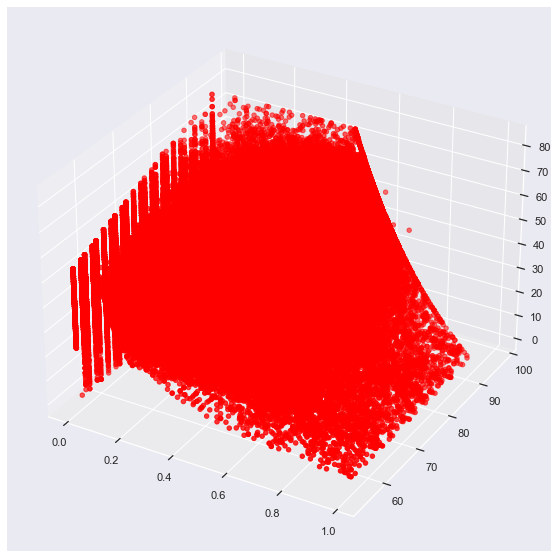

In [116]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
x = data[data['cluster']==0]['유수분']
y = data[data['cluster']==0]['탄력']
z = data[data['cluster']==0]['수분']

ax.scatter(x, y, z,color='red')
plt.show()

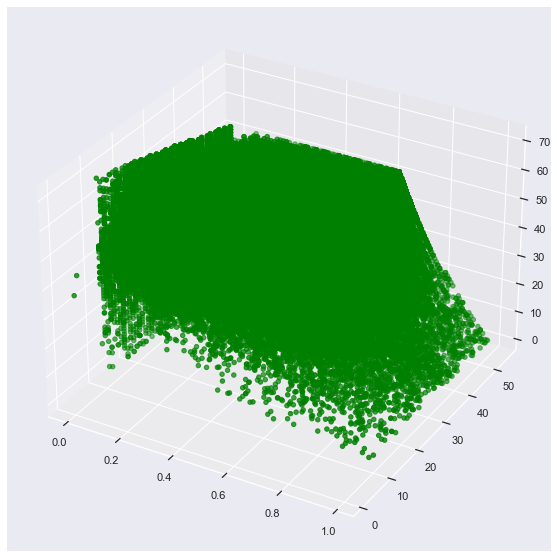

In [117]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
x = data[data['cluster']==1]['유수분']
y = data[data['cluster']==1]['탄력']
z = data[data['cluster']==1]['수분']

ax.scatter(x, y, z,color='green')
plt.show()

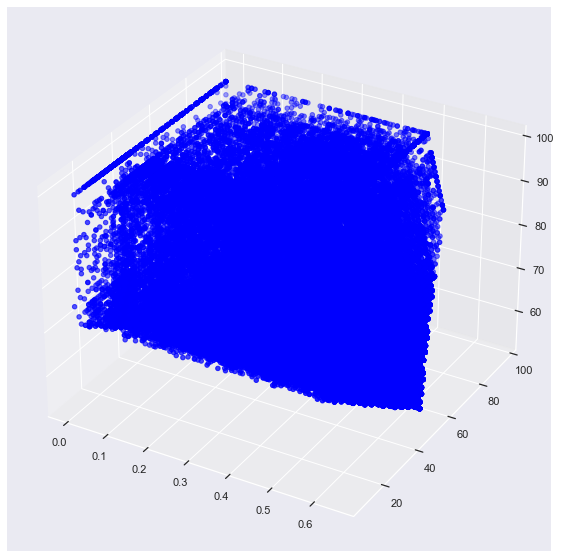

In [118]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
x = data[data['cluster']==2]['유수분']
y = data[data['cluster']==2]['탄력']
z = data[data['cluster']==2]['수분']
ax.scatter(x, y, z,color='blue')
plt.show()

In [ ]:
sns.scatterplot(x=data['유수분'],y=data['탄력'],hue=data['cluster'])

In [88]:
from sklearn.cluster import KMeans

k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

model.fit(data)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
data['cluster'] = model.fit_predict(data)

C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
